# Application Development Summative ML model for Solar generation

<div class="alert alert-block alert-info">
</b> Submitted by Hemal D. Patel</div>

### Objective

To Create a simple ML model application which accepts suitable inputs and gives a predicted power output for each power generation plant for any day within the next 7 days.

One for each genaration plant shall be created. 

The ML models shall be of Multiple Linear Regresssion.

### Load the data

Import the necessary libraries and load the data. Once loaded, investigate the data.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import os
import matplotlib.pyplot as pyplot
import pickle

%matplotlib inline

In [2]:
# confirm the path from which the data files shall be loaded;
os.getcwd()

'D:\\AIIP\\Application Development\\Summative_Final'

Load the monthly maintainance schedule and Annual Generation data files for the solar generation plant

In [4]:
# Solar Monthly Maintenance schedule;
# solar_monthly_schedule=pd.read_csv('solar_farm.csv') # load data description csv file on to a pandas data frame.

solar_monthly_schedule=pd.read_csv('solar_farm.csv', skiprows=1) # load csv file on to a pandas data frame. One Errenous row is
# skipped
wind_monthly_schedule=pd.read_csv('wind_farm.csv', skiprows=1)
print(solar_monthly_schedule)
print(wind_monthly_schedule)

   Date Of Month  Capacity Available
0              4                   3
1              6                   5
2             19                   2
3             23                  50
4             24                  20
5             25                   5
6             28                  10
    3  70
0   5  60
1   7  50
2   8  45
3  15  55
4  24  90
5  28  30


In [5]:
# Solar annual generation data;
solar_annual_gen=pd.read_csv('solar_generation_data.csv') # load solar geeneration data file on to a pandas data frame
print('\nAnnual Solar Generation Data\n',solar_annual_gen.iloc[0:5, :])
# Wind annual generation data
wind_annual_gen=pd.read_csv('wind_generation_data.csv') # load Wind geeneration data file on to a pandas data frame
print('\nAnnual Wind Generation Data\n',wind_annual_gen.iloc[0:5, :])


Annual Solar Generation Data
   Month   Day Temp Hi Temp Low  Solar  Cloud Cover Percentage  Rainfall in mm  \
0    Jan    1    109°      85°   30.0                       9             0.0   
1    Jan    2    106°      71°   30.1                       9             0.0   
2    Jan    3    106°      81°   29.5                       9             0.0   
3    Jan    4    102°      83°   13.0                       4             0.0   
4    Jan    5    105°      80°   30.1                       9             0.0   

   Power Generated in MW  
0                   9.93  
1                   9.97  
2                   9.77  
3                   4.30  
4                   9.97  

Annual Wind Generation Data
    wind speed  direction  Power Output
0       16.00        218         34.76
1       15.91        218         36.59
2       15.82        218         32.35
3       15.73        218         39.37
4       15.64        218         33.22


Additional data preparation

In [6]:
# Mapping month string values to numeric
month_num={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,
        'Nov':11,'Dec':12}

solar_annual_gen['Month_number']=solar_annual_gen.iloc[:,0].map(month_num)
solar_annual_gen

,Month,Day,Temp Hi,Temp Low,Solar,Cloud Cover Percentage,Rainfall in mm,Power Generated in MW,Month_number
0,Jan,1,109°,85°,30.0,9,0.0,9.93,1
1,Jan,2,106°,71°,30.1,9,0.0,9.97,1
2,Jan,3,106°,81°,29.5,9,0.0,9.77,1
3,Jan,4,102°,83°,13.0,4,0.0,4.30,1
4,Jan,5,105°,80°,30.1,9,0.0,9.97,1
...,...,...,...,...,...,...,...,...,...
360,Dec,27,101°,83°,26.4,8,NaN,8.74,12
361,Dec,28,102°,84°,25.8,8,NaN,8.54,12
362,Dec,29,104°,83°,26.9,8,NaN,8.91,12
363,Dec,30,105°,80°,25.1,8,NaN,8.31,12


In [7]:
# Remove the special character "°" and Convert Hi and low temp into floats

solar_annual_gen_temp=solar_annual_gen[["Temp Hi","Temp Low"]].replace('\°','',regex=True).astype(float)
solar_annual_gen_temp.columns = ['Temp Hi(float)','Temp Low(Float)']
solar_annual_gen_temp


,Temp Hi(float),Temp Low(Float)
0,109.0,85.0
1,106.0,71.0
2,106.0,81.0
3,102.0,83.0
4,105.0,80.0
...,...,...
360,101.0,83.0
361,102.0,84.0
362,104.0,83.0
363,105.0,80.0


In [8]:
# Merging high and low temp to original solar generation data frame

solar_annual_gen = pd.merge(solar_annual_gen, solar_annual_gen_temp, right_index=True, left_index=True)
solar_annual_gen

,Month,Day,Temp Hi,Temp Low,Solar,Cloud Cover Percentage,Rainfall in mm,Power Generated in MW,Month_number,Temp Hi(float),Temp Low(Float)
0,Jan,1,109°,85°,30.0,9,0.0,9.93,1,109.0,85.0
1,Jan,2,106°,71°,30.1,9,0.0,9.97,1,106.0,71.0
2,Jan,3,106°,81°,29.5,9,0.0,9.77,1,106.0,81.0
3,Jan,4,102°,83°,13.0,4,0.0,4.30,1,102.0,83.0
4,Jan,5,105°,80°,30.1,9,0.0,9.97,1,105.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...
360,Dec,27,101°,83°,26.4,8,NaN,8.74,12,101.0,83.0
361,Dec,28,102°,84°,25.8,8,NaN,8.54,12,102.0,84.0
362,Dec,29,104°,83°,26.9,8,NaN,8.91,12,104.0,83.0
363,Dec,30,105°,80°,25.1,8,NaN,8.31,12,105.0,80.0


### Explore the data

In [9]:
solar_annual_gen.describe() # summary statistics for all features or attributes

,Day,Solar,Cloud Cover Percentage,Rainfall in mm,Power Generated in MW,Month_number,Temp Hi(float),Temp Low(Float)
count,365.000000,365.000000,365.000000,312.000000,365.000000,365.000000,365.000000,365.000000
mean,15.720548,22.615068,6.972603,2.737179,7.488192,6.526027,91.687671,66.635616
std,8.808321,5.311600,1.699811,16.472178,1.759069,3.452584,10.281531,10.750484
min,1.000000,1.500000,1.000000,0.000000,0.500000,1.000000,66.000000,43.000000
25%,8.000000,18.500000,6.000000,0.000000,6.130000,4.000000,83.000000,58.000000
50%,16.000000,22.800000,7.000000,0.000000,7.550000,7.000000,93.000000,68.000000
75%,23.000000,27.000000,9.000000,0.000000,8.940000,10.000000,99.000000,75.000000
max,31.000000,30.200000,9.000000,161.500000,10.000000,12.000000,111.000000,94.000000


In [10]:
print(wind_annual_gen.describe()) # summary statistics for all features or attributes
# seems the data is for a little more than an year (366days) and therefore last row shall be dropped
wind_annual_gen=wind_annual_gen[0:365]

       wind speed   direction  Power Output
count  366.000000  366.000000    366.000000
mean    15.695792  220.081967     37.193607
std      3.743556    4.462796      7.243363
min      7.450000  209.000000     23.170000
25%     13.000000  218.000000     31.352500
50%     15.530000  220.000000     37.525000
75%     18.802500  222.000000     42.925000
max     22.710000  234.000000     51.810000


In [11]:
# mapping of Month_number and Day from solar data
solar_day_month=solar_annual_gen[['Day','Month_number']]

# Merge the data frames; solar_day_month to wind_annual_gen
wind_annual_gen=pd.merge(solar_day_month, wind_annual_gen, right_index=True, left_index=True)
wind_annual_gen

,Day,Month_number,wind speed,direction,Power Output
0,1,1,16.00,218,34.76
1,2,1,15.91,218,36.59
2,3,1,15.82,218,32.35
3,4,1,15.73,218,39.37
4,5,1,15.64,218,33.22
...,...,...,...,...,...
360,27,12,10.82,233,43.04
361,28,12,10.59,233,40.49
362,29,12,10.36,233,34.65
363,30,12,10.12,234,39.53


In [12]:
solar_annual_gen.info() # View of data types and count of val.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Month                   365 non-null    object 
 1   Day                     365 non-null    int64  
 2   Temp Hi                 365 non-null    object 
 3   Temp Low                365 non-null    object 
 4   Solar                   365 non-null    float64
 5   Cloud Cover Percentage  365 non-null    int64  
 6   Rainfall in mm          312 non-null    float64
 7   Power Generated in MW   365 non-null    float64
 8   Month_number            365 non-null    int64  
 9   Temp Hi(float)          365 non-null    float64
 10  Temp Low(Float)         365 non-null    float64
dtypes: float64(5), int64(3), object(3)
memory usage: 31.5+ KB


In [13]:
wind_annual_gen.info() # View of data types and count of val.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Day           365 non-null    int64  
 1   Month_number  365 non-null    int64  
 2   wind speed    365 non-null    float64
 3   direction     365 non-null    int64  
 4   Power Output  365 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 14.4 KB


In [14]:
#  Check for missing val
solar_annual_gen.isna().sum()

Month                      0
Day                        0
Temp Hi                    0
Temp Low                   0
Solar                      0
Cloud Cover Percentage     0
Rainfall in mm            53
Power Generated in MW      0
Month_number               0
Temp Hi(float)             0
Temp Low(Float)            0
dtype: int64

In [15]:
#  Check for missing val
wind_annual_gen.isna().sum()

Day             0
Month_number    0
wind speed      0
direction       0
Power Output    0
dtype: int64

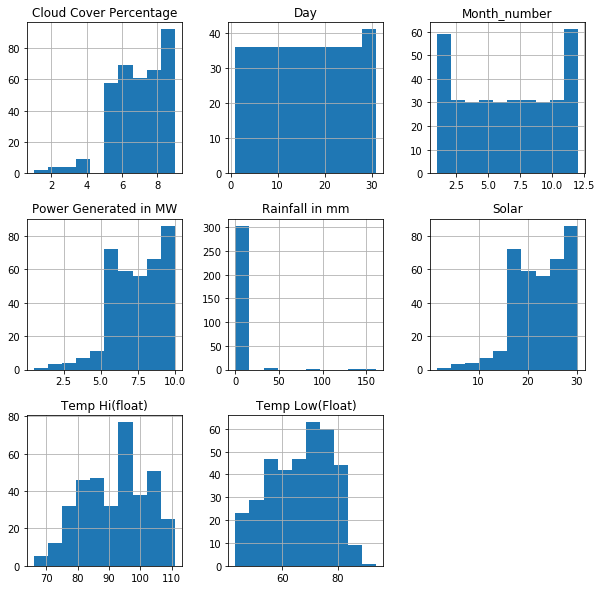

In [16]:
# Visualization of the features using Histogram
pd.DataFrame.hist(solar_annual_gen, figsize=(10,10)); # Histogram plots help to visualize the distribution characteristics. Very 
# few column values are normally distributed and therefore imputing missing values with median is preffered to reduce bias
# as a result of skewness or outliers

In [17]:
# Impute missing values with median i.e. Rainfall in mm with 53 missing value can be replaced with the median value (0) 
# imputing missing values with median is preffered to reduce bias as a result of skewness or outliers

solar_annual_gen["Rainfall in mm" ].fillna(solar_annual_gen["Rainfall in mm" ].median(), inplace=True) 

# Recheck for missing values
print(solar_annual_gen.isna().sum())  # view columns with NaN or missing values
print("\nNo. of columns containing atleast a null value=",len(solar_annual_gen.columns[solar_annual_gen.isna().any()]))
# solar_annual_gen.info()

Month                     0
Day                       0
Temp Hi                   0
Temp Low                  0
Solar                     0
Cloud Cover Percentage    0
Rainfall in mm            0
Power Generated in MW     0
Month_number              0
Temp Hi(float)            0
Temp Low(Float)           0
dtype: int64

No. of columns containing atleast a null value= 0


## The cleaned Solar Generation data frame can be saved as an object file using pickle in the the following  code;

In [18]:
# # Using pickling to save the cleaned data frame

# import pickle

# fileObj = open('Solar_anual_clean_data.obj', 'wb')
# pickle.dump(solar_annual_gen,fileObj)
# fileObj.close()

In [19]:
# #  Using pickling the cleaned data can be loaded
# import pickle   

# fileObj = open('Solar_anual_clean_data.obj', 'rb')
# solar_annual_gen = pickle.load(fileObj)
# fileObj.close()
# solar_annual_gen

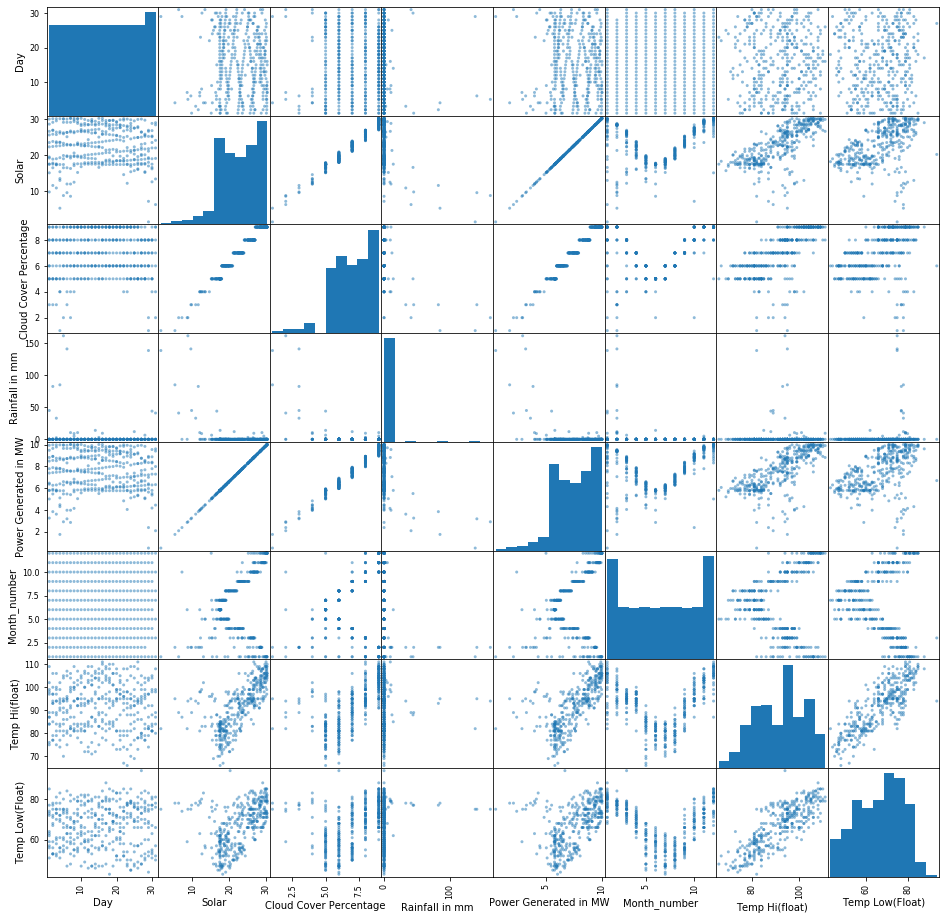

In [20]:
# Visualize the relationships between features

scatter_matrix(solar_annual_gen, figsize=(16,16));

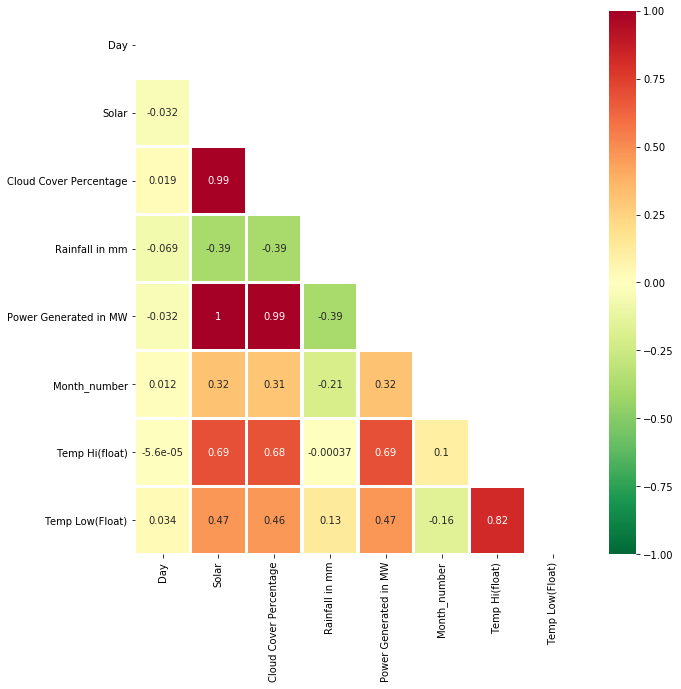

In [21]:
# Heatmap plot for viewing strength of corelations
plt.figure(figsize=(10,10))
corr_df = solar_annual_gen.corr(method='pearson')
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
# sns.heatmap(corr_df, cmap='RdYlGn_r',annot = True);

sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, annot = True);

# At a glance it is possible to see there is strong positive (dark red color) and medium negative (green color) 
# corelations amongst some variables


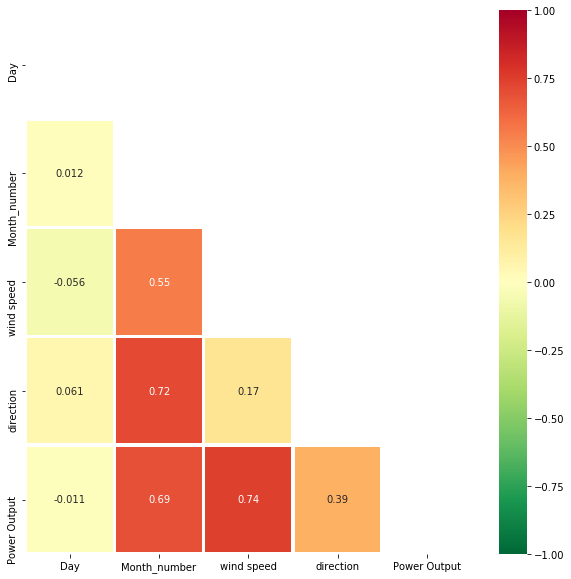

In [22]:
# Heatmap plot for viewing strength of corelations
plt.figure(figsize=(10,10))
corr_df = wind_annual_gen.corr(method='pearson')
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
# sns.heatmap(corr_df, cmap='RdYlGn_r',annot = True);

sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5, annot = True);

# At a glance it is possible to see there is strong positive (red color) and no negative (green color) 
# corelations amongst some variables


In [23]:
# solar_annual_gen.insert(0, "Year", 2000) # An arbitrary year is selected since it is unknown and the column is created 

In [24]:
# solar_annual_gen.head()

In [25]:
# # # Combining the three date strings (day,month and year)
# solar_annual_gen['Full Date']=solar_annual_gen['Day'].map(str)+solar_annual_gen['Month '] +solar_annual_gen['Year'].map(str)
# solar_annual_gen


In [26]:
# # # Converting the date string to datetime data type 
# solar_annual_gen['Full Date'] = pd.to_datetime(solar_annual_gen['Full Date'], format='%d%b%Y', errors='coerce')
# print(solar_annual_gen.info())

In [27]:
# # # Plotting of time series
# from pandas import Series

# ts = Series(solar_annual_gen['Power Generated in MW'].values, solar_annual_gen['Full Date'] ) 
# plt = ts[1:1000].plot()
# pyplot.show(plt)

# #  From the time series plot the solar generation drops mid year and peaks during the start and end of the year

In [28]:
# solar_annual_gen.columns

In [29]:
# solar_annual_gen=solar_annual_gen.drop('Year', axis=1)
# solar_annual_gen

### Split dataset into predictor and target matrices & Create model and save using pickling

In [32]:
from sklearn import model_selection

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

solar_annual_gen_numeric = solar_annual_gen.select_dtypes(include=numerics) # Include only numeric data types
# wind_annual_gen_numeric = wind_annual_gen.select_dtypes(include=numerics) # already all are numeric data types in wind data 
print('\nSolar Generation data columns for use in model;\n',solar_annual_gen_numeric.columns)
print('\nWind Generation data columns for use in model;\n',wind_annual_gen.columns)


Solar Generation data columns for use in model;
 Index(['Day', 'Solar', 'Cloud Cover Percentage', 'Rainfall in mm',
       'Power Generated in MW', 'Month_number', 'Temp Hi(float)',
       'Temp Low(Float)'],
      dtype='object')

Wind Generation data columns for use in model;
 Index(['Day', 'Month_number', 'wind speed', 'direction', 'Power Output'], dtype='object')


In [33]:
from sklearn import model_selection

# Split dataset into predictor and target matrices

# Values of target
y = solar_annual_gen_numeric['Power Generated in MW'].values
y1= wind_annual_gen['Power Output'].values

# Values of attributes
# For Solar, Drop the target value and 'Rainfall in mm'(no data from the weather forecast data)
# For Wind, Drop the target value
solar_annual_gen_X = solar_annual_gen_numeric.drop(['Power Generated in MW','Rainfall in mm'], axis=1)
wind_annual_gen_X = wind_annual_gen.drop(['Power Output'], axis=1)
X = solar_annual_gen_X.values
X1 = wind_annual_gen_X.values
print('Solar Target Values y=',y[:10]) # View first 10 Target values
print('\nSolar Attribute Values X=',X[:3]) # view of 3no. rows of Attribute Values
print('\nWind Target Values y1=',y1[:10]) # View first 10 Target values
print('\nWind Attribute Values X1=',X1[:3]) # view of 3no. rows of Attribute Values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)# Use test size of 25% for better
# performance

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=0)# Use test size of 25% for better
# performance

Solar Target Values y= [ 9.93  9.97  9.77  4.3   9.97  8.71 10.    9.87  9.97  8.97]

Solar Attribute Values X= [[  1.   30.    9.    1.  109.   85. ]
 [  2.   30.1   9.    1.  106.   71. ]
 [  3.   29.5   9.    1.  106.   81. ]]

Wind Target Values y1= [34.76 36.59 32.35 39.37 33.22 37.09 41.23 32.72 40.39 37.54]

Wind Attribute Values X1= [[  1.     1.    16.   218.  ]
 [  2.     1.    15.91 218.  ]
 [  3.     1.    15.82 218.  ]]


In [34]:
print('Columns for solar attributes',solar_annual_gen_X.columns) 
print('\nColumns for wind attributes',wind_annual_gen_X.columns)

Columns for solar attributes Index(['Day', 'Solar', 'Cloud Cover Percentage', 'Month_number',
       'Temp Hi(float)', 'Temp Low(Float)'],
      dtype='object')

Columns for wind attributes Index(['Day', 'Month_number', 'wind speed', 'direction'], dtype='object')


In [35]:
# Fit the model on training set
solarmodel = RandomForestRegressor(n_estimators=30, random_state=0, n_jobs=-1)
solarmodel.fit(X_train, y_train)
windmodel = RandomForestRegressor(n_estimators=30, random_state=0, n_jobs=-1)
windmodel.fit(X1_train, y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [37]:
# Save Model Using Pickle
import pickle
pickle.dump(solarmodel, open('solar_model.pkl','wb'))
pickle.dump(windmodel, open('wind_model.pkl','wb'))

In [38]:
# Predict solar output
y_pred = solarmodel.predict(X_test)
y_pred

array([7.116     , 7.84433333, 9.43933333, 7.617     , 8.44      ,
       9.901     , 7.78033333, 9.698     , 7.10633333, 9.996     ,
       6.483     , 6.06033333, 8.06433333, 8.964     , 7.32433333,
       6.28266667, 8.225     , 7.483     , 6.51666667, 6.116     ,
       5.79133333, 6.04466667, 8.76666667, 9.116     , 8.85933333,
       7.7       , 8.764     , 8.77366667, 6.864     , 5.91333333,
       6.57033333, 7.41133333, 8.77566667, 3.998     , 9.10066667,
       8.695     , 8.906     , 6.31433333, 7.85666667, 8.28133333,
       6.18666667, 9.396     , 6.37333333, 8.005     , 9.858     ,
       8.90866667, 6.235     , 6.28733333, 7.13666667, 8.84933333,
       5.76      , 6.55966667, 7.04866667, 5.79      , 7.84966667,
       7.059     , 9.34933333, 5.87      , 8.05366667, 8.51666667,
       8.98066667, 8.325     , 9.86333333, 7.48266667, 9.53533333,
       9.972     , 8.24766667, 5.758     , 6.56166667, 5.82966667,
       8.531     , 5.76      , 6.743     , 9.154     , 8.525  

In [39]:
# Predict wind output
y1_pred = windmodel.predict(X1_test)
y1_pred

array([29.53933333, 47.807     , 31.63866667, 32.73366667, 30.95066667,
       42.359     , 31.05566667, 44.55166667, 46.16666667, 37.26866667,
       28.768     , 28.465     , 46.26066667, 46.89833333, 42.76766667,
       39.63      , 44.04566667, 28.79866667, 43.88666667, 29.472     ,
       29.56266667, 36.81933333, 32.05233333, 47.21666667, 44.31633333,
       43.925     , 28.54233333, 42.291     , 28.324     , 37.74833333,
       31.04566667, 28.23333333, 35.61366667, 32.20533333, 31.28966667,
       35.19166667, 32.368     , 31.30866667, 47.80433333, 28.28466667,
       41.72433333, 43.86933333, 42.376     , 46.41333333, 31.93466667,
       46.611     , 41.26133333, 44.21033333, 42.904     , 28.16766667,
       32.19266667, 42.401     , 42.824     , 34.657     , 31.137     ,
       30.67233333, 32.89733333, 30.192     , 28.06333333, 32.14033333,
       44.902     , 44.82666667, 38.805     , 24.76666667, 44.042     ,
       43.29066667, 29.46166667, 28.65533333, 44.95566667, 30.76

### Evaluate the results

Using the `sklearn.metrics` moduel determine the accuracy score, i.e., the coefficient of determination $R^2$ of the prediction.

In [40]:
# Score
print('\nSolar Model train set Score=',solarmodel.score(X_train, y_train))
print('\nSolar Model test set Score=',solarmodel.score(X_test, y_test))

print('\nWind Model train set Score=',windmodel.score(X1_train, y1_train))
print('\nWind Model test set Score=',windmodel.score(X1_test, y1_test))

"""The model performance for solar is good and has generalized well with the unseen test data set. There is a small difference
between the test and training data set scores and both have performed well. There is no overfitting and no underfitting.""" 

"""The model performance for Wind is not so bad. There is a bit of a difference between the training data and test data set 
scores and thus a little overfitting."""


Solar Model train set Score= 0.9994778563067632

Solar Model test set Score= 0.9995756375078141

Wind Model train set Score= 0.9569685762904437

Wind Model test set Score= 0.7797830726180897


'The model performance for Wind is not so bad. There is a bit of a difference between the training data and test data set \nscores and thus a little overfitting.'

In [41]:
# R2 Score
print('Solar R2 Score=',r2_score(y_test, y_pred))
print('Wind R2 Score=',r2_score(y1_test, y1_pred))

# Model accuracy is good for solar as compared to wind. The R2 score of 99% means the regression model fits the observations
# very well for solar 

Solar R2 Score= 0.9995756375078141
Wind R2 Score= 0.7797830726180897


In [42]:
# Model Predictions
print('y_test[20]=',y_test[20],'y_pred[20]=',y_pred[20])
print('y1_test[20]=',y1_test[20],'y1_pred[20]=',y1_pred[20])
# print('\ny_test[400],y_pred=',y_test[400],'y_pred[400]=',y_pred[400])
# print('\ny_test[800],y_pred=',y_test[800],'y_pred[800]=',y_pred[800])

y_test[20]= 5.79 y_pred[20]= 5.791333333333335
y1_test[20]= 35.88 y1_pred[20]= 29.56266666666666


In [43]:
# Comparing the actual output values for X_test with the predicted values
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
print(df)
df.describe()

# Summary statistics also displays similarities in the mean, standard deviation,median, interquartile range and etc. 
# for the Power Generated in MW for the Actual and Predicted  

    Actual  Predicted
0     7.09   7.116000
1     7.91   7.844333
2     9.44   9.439333
3     7.62   7.617000
4     8.44   8.440000
..     ...        ...
87    6.16   6.154333
88    8.28   8.264667
89    8.81   8.769333
90    8.77   8.769000
91    8.34   8.317333

[92 rows x 2 columns]


,Actual,Predicted
count,92.000000,92.000000
mean,7.815652,7.807986
std,1.397398,1.397421
min,3.970000,3.998000
25%,6.550000,6.548917
50%,7.965000,8.029333
75%,8.880000,8.871000
max,10.000000,9.997000


In [44]:
# Comparing the actual output values for X_test with the predicted values
df1 = pd.DataFrame({'Actual': y1_test.flatten(), 'Predicted': y1_pred.flatten()})
print(df1)
df1.describe()

# Summary statistics also displays similarities in the mean, standard deviation,median, interquartile range and etc. 
# for the Power Generated in MW for the Actual and Predicted  

    Actual  Predicted
0    29.03  29.539333
1    45.38  47.807000
2    33.22  31.638667
3    31.44  32.733667
4    24.46  30.950667
..     ...        ...
87   43.82  38.745000
88   49.77  43.486667
89   46.22  43.392333
90   43.92  47.077000
91   29.74  35.013000

[92 rows x 2 columns]


,Actual,Predicted
count,92.000000,92.000000
mean,37.162065,37.203736
std,7.787419,6.836401
min,23.190000,24.766667
25%,30.975000,31.021917
50%,37.625000,37.044000
75%,43.977500,43.873667
max,50.240000,47.807000


 ### **<font color=blue>Conclusion<br><font color=blue>The model performance and accuracy are good at 99% and therefore the model is able to predict the Solar generated power(MW)  with about 99% accuracy </font>**